# Qiskit Ignis
## Quantum Error ?
Quantum errors(noise) on QC are caused by physical phenomena.
* Heat
* Oscillation
* Electromagnetic wave 

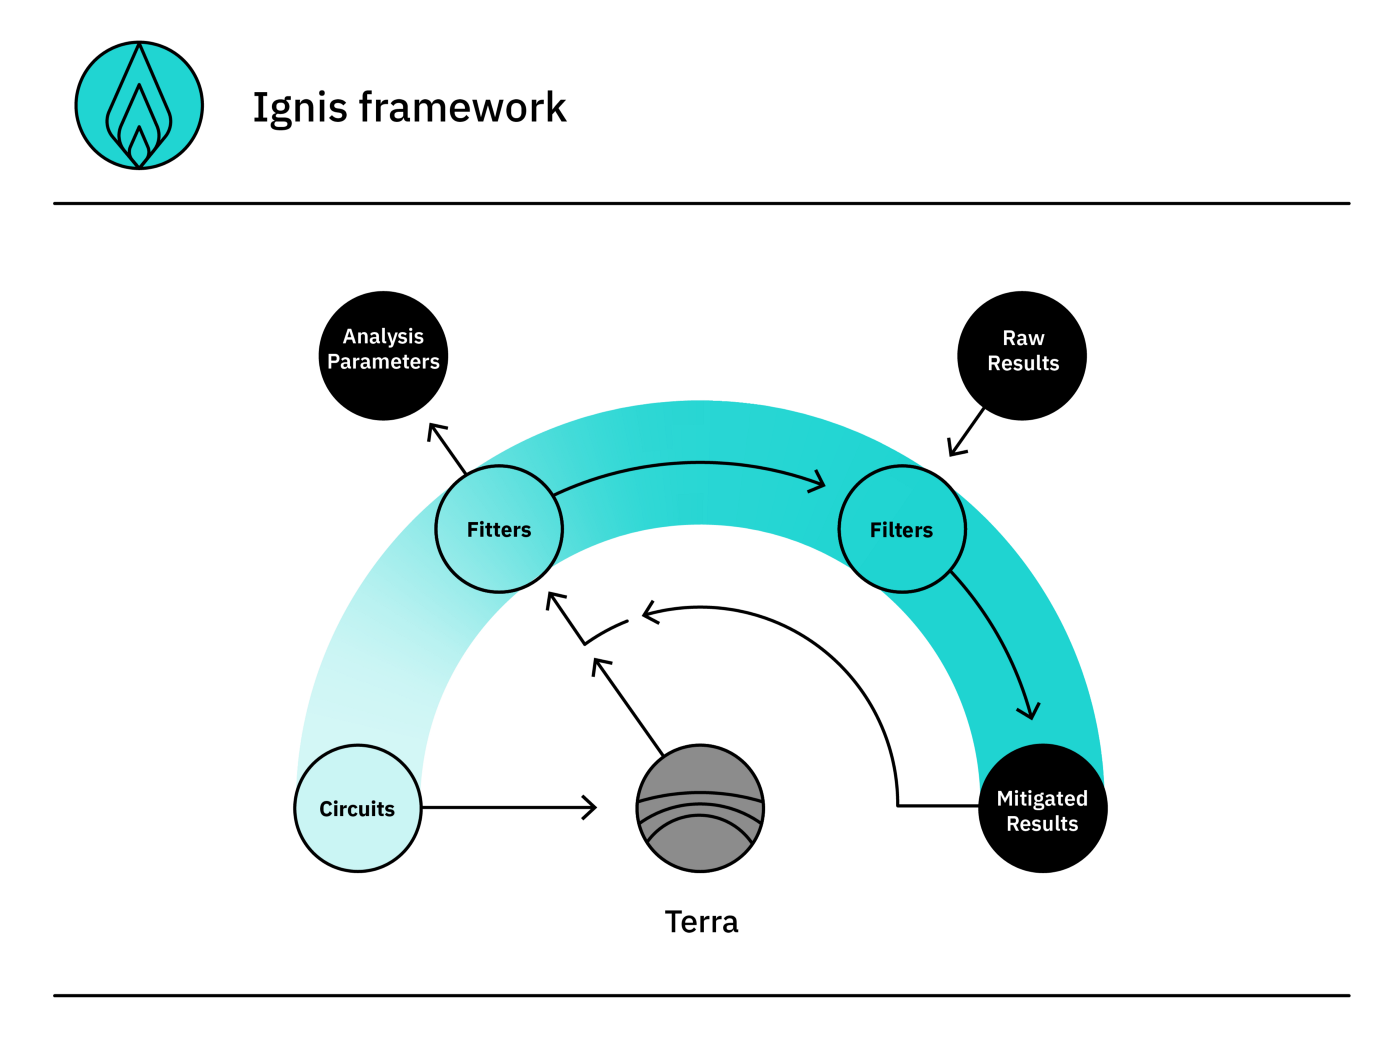

# Ignis provides…
Ignis provides tools for noise estimation and correction.
* Characterization experiments to measure
* State and Process Tomography
* Randomized Benchmarking 
* Measurement Error Mitigation
* Quantum Volume

# Error model

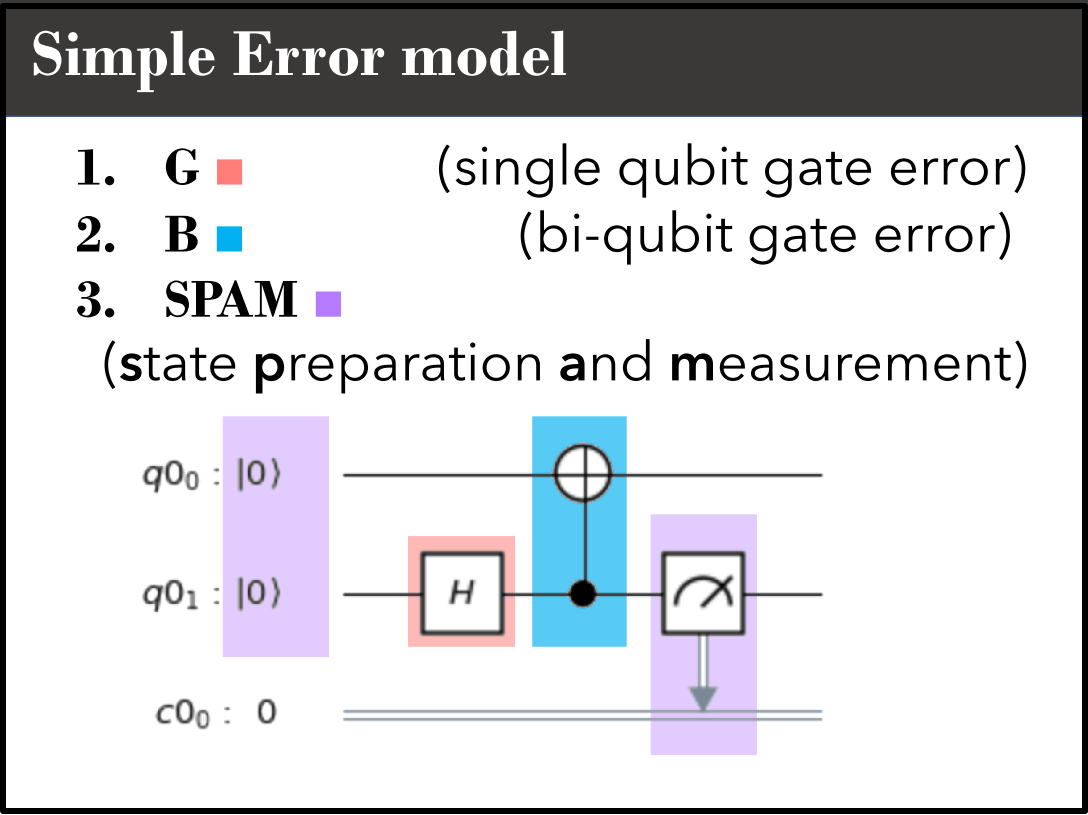

# 1. Characterization experiments to measure
Stochastic noise parameters such as T1 and T2. The value that was evaluated whether the condition was maintained when left.

https://github.com/Qiskit/qiskit-tutorials/blob/master/qiskit/ignis/relaxation_and_decoherence.ipynb

# 2. State and Process Tomography
An experimental procedure to reconstruct a description of part of quantum system from the measurement outcomes of a specific set of experiments. 

https://github.com/Qiskit/qiskit-tutorials/blob/e32d94ec578a798acada2616032bf47a1a541c5f/community/ignis/tomography-overview.ipynb

# 3. Randomized benchmarking
Tools to general one- and two-qubit random Clifford sequences in parallel.
Analysis of the data to determine average gate error. 

https://github.com/Qiskit/qiskit-tutorials/blob/master/qiskit/ignis/randomized_benchmarking.ipynb
* See the frequency of noise at a lighter cost than tomography
* Use randomness for evaluate cost of  whole gate set
* Separate SPAM error and gate error
* Clifford group (gate set)

# 4. Measurement Error Mitigation
Tools to generate the circuits and analysis to construct a measurement calibration.
Filter object that can be applied to results to mitigate measurement errors. 

https://github.com/Qiskit/qiskit-tutorials/blob/e32d94ec578a798acada2616032bf47a1a541c5f/community/ignis/measurement_error_mitigation.ipynb

# 5. Quantum Volume
1. The number of physical qubits 
2. The number of gates that can be applied before errors make the device behave essentially classically
3. The connectivity of the device
4. The number of operations that can be run in parallel.

https://github.com/Qiskit/qiskit-tutorials/blob/master/qiskit/ignis/quantum_volume.ipynb

# Measurement Error Mitigation

* **Requires:** qiskit-terra 0.8, qiskit-ignis 0.1.1, qiskit-aer 0.2
* **Modified from:** https://github.com/Qiskit/qiskit-tutorials/blob/master/qiskit/ignis/measurement_error_mitigation.ipynb

## Introduction

The measurement calibration is used to mitigate measurement errors. 
The main idea is to prepare all $2^n$ basis input states and compute the probability of measuring counts in the other basis states. 
From these calibrations, it is possible to correct the average results of another experiment of interest. This notebook gives examples for how to use the ``ignis.mitigation.measurement`` module.

In [1]:
# Import general libraries (needed for functions)
import numpy as np
import time
import matplotlib
from qiskit import IBMQ

# Import Qiskit classes
import qiskit 
from qiskit import QuantumRegister, QuantumCircuit, ClassicalRegister, Aer
from qiskit.providers.aer import noise
from qiskit.tools.visualization import plot_histogram

# Import measurement calibration functions
from qiskit.ignis.mitigation.measurement import (complete_meas_cal, tensored_meas_cal,
                                                 CompleteMeasFitter, TensoredMeasFitter)

In [2]:
TOKEN = 'MY_TOKEN' # Replace MY_TOKEN with your TOKEN
IBMQ.save_account(TOKEN, overwrite=True)

In [3]:
# Load account from disk
provider = IBMQ.load_account()
# List the account currently in the session
print(IBMQ.active_account())
# List all available providers
print(IBMQ.providers())
# List all available providers 
print(provider.backends())

{'token': 'a68ed5f01ae762a863d05960b20488a24b834174d145ba4bea63975b06d4bd534f10e0659a8ec4f79c23ff61daa64294b82d531d6cf08fcdcdba7661371f9a09', 'url': 'https://auth.quantum-computing.ibm.com/api'}
[<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>, <AccountProvider for IBMQ(hub='ibm-q-hub-ntu', group='ntu-internal', project='default')>]
[<IBMQSimulator('ibmq_qasm_simulator') from IBMQ(hub='ibm-q', group='open', project='main')>, <IBMQBackend('ibmqx4') from IBMQ(hub='ibm-q', group='open', project='main')>, <IBMQBackend('ibmqx2') from IBMQ(hub='ibm-q', group='open', project='main')>, <IBMQBackend('ibmq_16_melbourne') from IBMQ(hub='ibm-q', group='open', project='main')>]


## 3 Qubit Example of the Calibration Matrices

Assume that we would like to generate a calibration matrix for the 3 qubits Q2, Q3 and Q4 in a 5-qubit Quantum Register [Q0,Q1,Q2,Q3,Q4]. 

Since we have 3 qubits, there are $2^3=8$ possible quantum states.

## Generating Measurement Calibration Circuits 

First, we generate a list of measurement calibration circuits for the full Hilbert space. 
Each circuit creates a basis state. 
If there are $n=3$ qubits, then we get $2^3=8$ calibration circuits.

The following function **complete_meas_cal** returns a list **meas_calibs** of QuantumCircuit objects containing the calibration circuits, 
and a list **state_labels** of the calibration state labels.

The input to this function can be given in one of the following three forms:

- **qubit_list:** A list of qubits to perform the measurement correction on, or:
- **qr (QuantumRegister):** A quantum register, or:
- **cr (ClassicalRegister):** A classical register.

In addition, one can provide a string **circlabel**, which is added at the beginning of the circuit names for unique identification.

For example, in our case, the input is a 5-qubit QuantumRegister containing the qubits Q2,Q3,Q4:

In [4]:
# Generate the calibration circuits
qr = qiskit.QuantumRegister(5)
# The qubits to be calibrated
qubit_list = [2,3,4]
# Generate calibration circuit
meas_calibs, state_labels = complete_meas_cal(qubit_list=qubit_list, qr=qr, circlabel='mcal')

Print the $2^3=8$ state labels (for the 3 qubits Q2,Q3,Q4):

In [5]:
state_labels

['000', '001', '010', '011', '100', '101', '110', '111']

## Computing the Calibration Matrix

If we do not apply any noise, then the calibration matrix is expected to be the $8 \times 8$ identity matrix.

In [6]:
# Execute the calibration circuits without noise
backend = qiskit.Aer.get_backend('qasm_simulator')
job = qiskit.execute(meas_calibs, backend=backend, shots=1000)
cal_results = job.result()

## Computing the Calibration Matrix without noise

In [7]:
# The calibration matrix without noise is the identity matrix
meas_fitter = CompleteMeasFitter(cal_results, state_labels, circlabel='mcal')
print(meas_fitter.cal_matrix)

[[1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]]


Assume that we apply some noise model from Qiskit Aer to the 5 qubits, 
then the calibration matrix will have most of its mass on the main diagonal, with some additional 'noise'.

Alternatively, we can execute the calibration circuits using IBMQ provider.

## Calculating the Calibration Matrix read_out noise model

In [8]:
# Generate a noise model for the 5 qubits
noise_model = noise.NoiseModel()
for qi in range(5):
    # Binary channel for each qubit 
    read_err = noise.errors.readout_error.ReadoutError([[0.9, 0.1],[0.25,0.75]])
    noise_model.add_readout_error(read_err, [qi])

In [9]:
# Execute the calibration circuits
backend = qiskit.Aer.get_backend('qasm_simulator')
job = qiskit.execute(meas_calibs, backend=backend, shots=1000, noise_model=noise_model)
cal_results = job.result()

In [10]:
# Calculate the calibration matrix with the noise model
meas_fitter = CompleteMeasFitter(cal_results, state_labels, qubit_list=qubit_list, circlabel='mcal')
print(meas_fitter.cal_matrix)

[[0.719 0.201 0.211 0.065 0.201 0.053 0.052 0.017]
 [0.089 0.606 0.028 0.145 0.013 0.18  0.008 0.046]
 [0.085 0.016 0.611 0.169 0.019 0.004 0.185 0.043]
 [0.004 0.06  0.064 0.521 0.003 0.021 0.018 0.159]
 [0.083 0.032 0.023 0.006 0.641 0.167 0.139 0.044]
 [0.013 0.078 0.002 0.025 0.053 0.518 0.022 0.145]
 [0.007 0.    0.053 0.013 0.061 0.012 0.515 0.132]
 [0.    0.007 0.008 0.056 0.009 0.045 0.061 0.414]]


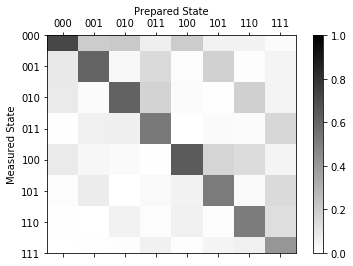

In [11]:
# Plot the calibration matrix
meas_fitter.plot_calibration()

## Applying the Calibration

We now perform another experiment and correct the measured results. 

## Correct Measurement Noise on a 3Q GHZ State

As an example, we start with the 3-qubit GHZ state on the qubits Q2,Q3,Q4:

$$ \mid GHZ \rangle = \frac{\mid{000} \rangle + \mid{111} \rangle}{\sqrt{2}}$$

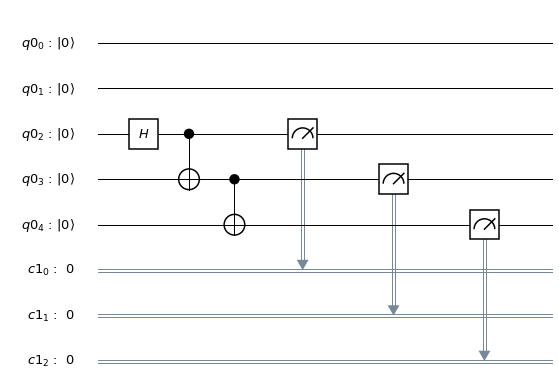

In [12]:
# Make a 3Q GHZ state
cr = ClassicalRegister(3)
ghz = QuantumCircuit(qr, cr)
ghz.h(qr[2])
ghz.cx(qr[2], qr[3])
ghz.cx(qr[3], qr[4])
ghz.measure(qr[2],cr[0])
ghz.measure(qr[3],cr[1])
ghz.measure(qr[4],cr[2])
ghz.draw(output='mpl')

We now execute the calibration circuits (with the noise model above)

In [13]:
job = qiskit.execute(ghz, backend=backend, shots=1000, noise_model=noise_model)
results = job.result()

We now compute the results without any error mitigation and with the mitigation, namely after applying the calibration matrix to the results.

There are two fitting methods for applying thr calibration (if none method is defined, then 'least_squares' is used). 
- **'pseudo_inverse'**, which is a direct inversion of the calibration matrix, 
- **'least_squares'**, which constrained to have physical probabilities.

The raw data to be corrected can be given in a number of forms:

- Form1: A counts dictionary from results.get_counts,
- Form2: A list of counts of length=len(state_labels),
- Form3: A list of counts of length=M*len(state_labels) where M is an integer (e.g. for use with the tomography data),
- Form4: A qiskit Result (e.g. results as above).

In [14]:
# Results without mitigation
raw_counts = results.get_counts()

# Get the filter object
meas_filter = meas_fitter.filter

# Results with mitigation
mitigated_results = meas_filter.apply(results)
mitigated_counts = mitigated_results.get_counts(0)

We can now plot the results with and without error mitigation:

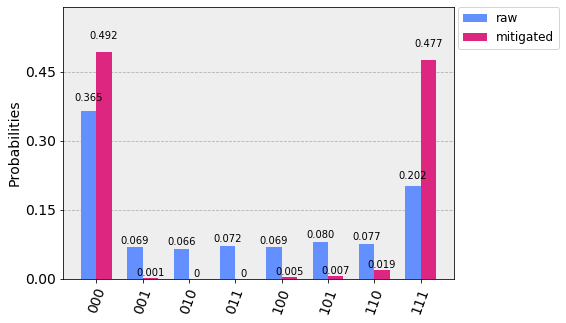

In [15]:
from qiskit.tools.visualization import *
plot_histogram([raw_counts, mitigated_counts], legend=['raw', 'mitigated'])